In [ ]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

In [2]:
def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

In [3]:
def distplot(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax.set_title('MCC9 Data/MC',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels)
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

In [4]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax=-1):
    
    writepval=True
    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)

    a_labels_evts = []

    for i in range(len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())

    yerr_mc = np.sqrt(yerr_mc)

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    if ymax < 0: ymax = vals_data.max()*1.35
    
    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc,where=vals_mc!=0),2) + np.power(np.divide(np.sqrt(vals_data),vals_data,where=vals_data!=0),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc,where=vals_mc!=0)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, np.count_nonzero(er_rat)-1)


    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))


    plt.tight_layout()
    print('Events:',vals_data.sum())
    print('MC: ',vals_mc.sum())
    print('Max Bin ct (data):',vals_data.max())
    print('Min Bin ct (data):',vals_data.min())
    return ax0


## Load  Things Up

In [5]:
DIRT_POT = 3.2571504301e+20
NUMU_POT = 1.219190611900899e+21
NUE_POT = 1.31390317541e+23

# As of feb 14 (NEED TO XCHECK DATA POT)
DATA_POT = 4.4e19    #3.456e+19
EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

# in future, find (negligible) emptyboys     

POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

In [12]:
tag = 'Feb13-allclean'
df_data_presel = pd.read_parquet('../data/pickles/data_goodruns_precuts_%s.parquet'%tag)
df_numu_presel = pd.read_parquet('../data/pickles/numu_goodruns_precuts_%s.parquet'%tag)
df_nue_presel = pd.read_parquet('../data/pickles/nue_goodruns_precuts_%s.parquet'%tag)
df_ext_presel = pd.read_parquet('../data/pickles/ext_goodruns_precuts_%s.parquet'%tag)
df_dirt_presel = pd.read_parquet('../data/pickles/dirt_goodruns_precuts_%s.parquet'%tag)

In [13]:
weights_numu_presel = CV(df_numu_presel)*NUMU_SCALE
weights_nue_presel = CV(df_nue_presel)*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = CV(df_dirt_presel)*DIRT_SCALE

a_weights = [weights_numu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','Joe Dirt','EXTBNB']
a_colors = ['mediumspringgreen','c','brown','mediumorchid']

Events: 27075.0
MC:  26073.99324242372
Max Bin ct (data): 1657.0
Min Bin ct (data): 65.0


Text(0.7, 0.7, 'Fiducial, Two-Track,and \\nContainment Cuts Applied')

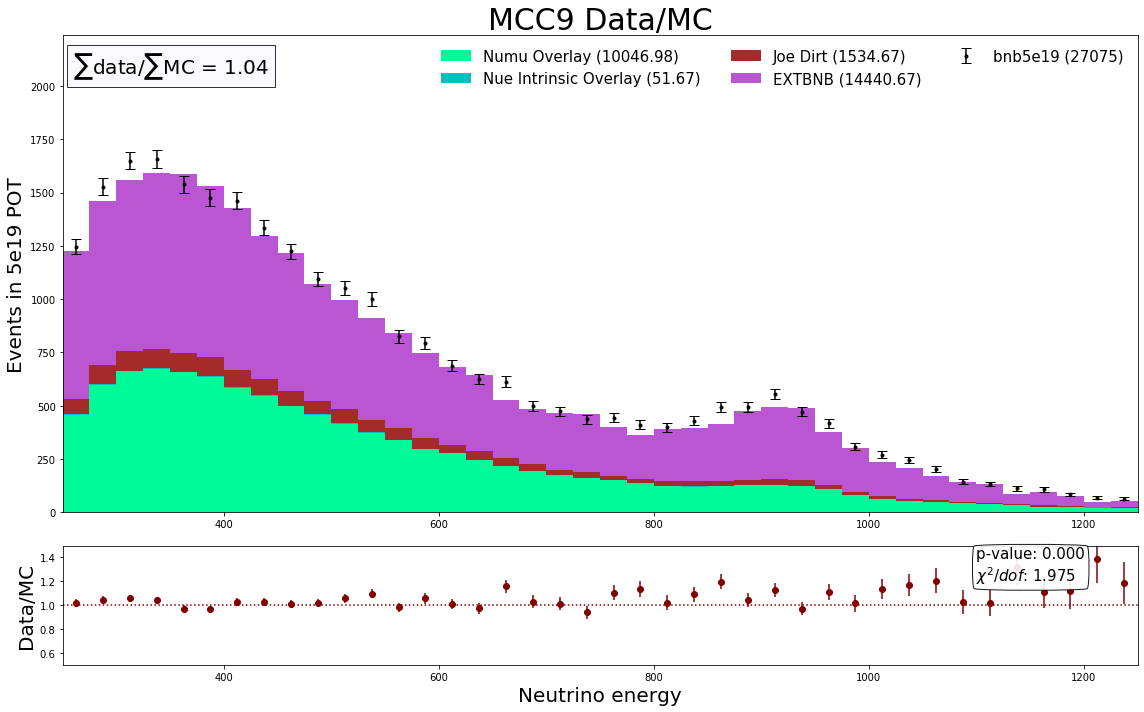

In [14]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
var_dirt = df_dirt_presel['Enu_1m1p'].values

fig,ax = plt.subplots(figsize=(16,10))
distplot_wratio(40,(250,1250),[var_numu,var_nue,var_dirt,var_ext],var_data,weights_data_presel,'Neutrino energy')
ax.annotate(r'Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)

## This is where the magic happens

In [ ]:
df_numu_CCQE_presel = df_numu_presel.query("mc_label in ['numu_CCQE']")
df_numu_MEC_presel = df_numu_presel.query("mc_label in ['numu_MEC']")
df_numu_pizero_presel = df_numu_presel.query("mc_label in ['numu_pizero']")
df_numu_piplusminus_presel = df_numu_presel.query("mc_label in ['numu_piplusminus']")
df_bnb_other_presel = df_numu_presel.query("mc_label not in ['nue_offvtx','numu_offvtx','numu_CCQE','numu_MEC','numu_pizero','numu_piplusminus']")
df_bnboverlay_offvtx_presel = df_numu_presel.query("mc_label in ['nue_offvtx','numu_offvtx']")

df_nue_CC_presel = df_nue_presel.query("mc_label not in ['nue_offvtx']")
df_nue_offvtx_presel = df_nue_presel.query("mc_label in ['nue_offvtx']")

df_bnb_offvtx_presel = pd.concat([df_bnboverlay_offvtx_presel,df_nue_offvtx_presel],sort=False)

In [ ]:
weights_bnb_offvtx_presel = np.concatenate((CV(df_bnboverlay_offvtx_presel)*NUMU_SCALE,CV(df_nue_offvtx_presel)*NUE_SCALE))
weights_numu_CCQE_presel = CV(df_numu_CCQE_presel)*NUMU_SCALE
weights_numu_MEC_presel = CV(df_numu_MEC_presel)*NUMU_SCALE
weights_numu_pizero_presel = CV(df_numu_pizero_presel)*NUMU_SCALE
weights_numu_piplusminus_presel = CV(df_numu_piplusminus_presel)*NUMU_SCALE
weights_bnb_other_presel = CV(df_bnb_other_presel)*NUMU_SCALE
weights_nue_CC_presel = CV(df_nue_CC_presel)*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = CV(df_dirt_presel)*DIRT_SCALE

a_weights = [weights_numu_CCQE_presel,weights_numu_MEC_presel,weights_numu_pizero_presel,weights_numu_piplusminus_presel,weights_bnb_other_presel,weights_bnb_offvtx_presel,weights_nue_CC_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'BNB Other','BNB Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','peru','fuchsia']

In [ ]:
vartest = 'Enu_1m1p'
varname = vartest
myrange = (250,1250)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'PzEnu_1m1p'
varname = vartest
myrange = (-2000,500)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'Thetas'
varname = vartest
myrange = (0,2*np.pi)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'Lepton_ThetaReco'
varname = vartest
myrange = (0,np.pi)
nbins = 20
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'OpenAng'
varname = vartest
myrange = (0,np.pi)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'Sph_1m1p'
varname = vartest
myrange = (0,4000)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'ChargeNearTrunk'
varname = vartest
myrange = (0,1000)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'Lepton_PhiReco'
varname = vartest
myrange = (-np.pi,np.pi)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'ShortTrackLen'
varname = vartest
myrange = (5,150)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'PTRat_1m1p'
varname = vartest
myrange = (0,1)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'TotPE'
varname = vartest
myrange = (0,1000)
nbins = 30
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

In [ ]:
vartest = 'MaxPEFrac'
varname = vartest
myrange = (.05,.6)
nbins = 40
yscale = 1.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[0].hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(var_ccqe,nbins,range=myrange,color='blue',alpha=.4,label='ccqe',density=1)
_ = ax[1].hist(var_nubkg,nbins,range=myrange,color='maroon',alpha=.4,label='nubkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

# Weight the bdts

In [ ]:
df_signal = df_numu_presel.query('MC_scedr < 5')
df_extbkg = pd.concat([df_ext_presel,df_bnb_offvtx_presel],sort=False)
df_nubkg = pd.concat([df_numu_piplusminus_presel,df_numu_pizero_presel,df_bnb_other_presel,df_numu_MEC_presel],sort=False)

In [ ]:
# Cosmic vs numu
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']
vars_vd = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
vars_vd2 = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']
vars_vd4 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Thetas','Phis','PTRat_1m1p','LongTrackLen']# ,'TotPE','MaxPEFrac']
vars_cos_vd0 = ['ChargeNearTrunk','OpenAng','PzEnu_1m1p','Thetas','Sph_1m1p','Lepton_PhiReco','Proton_PhiReco','LongTrackLen']

testo = ['Eta','ChargeNearTrunk','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','PTRat_1m1p','LongTrackLen']
stronk = ['OpenAng','Thetas','PzEnu_1m1p']

myvars = vars_vd4

X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=6, 
                      gamma=5)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = cosmicBDT.predict(X ,output_margin=True)
bdt_score_ext = cosmicBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-10,10),alpha = .5,density=1,label='EXT')

plt.legend()

In [ ]:
pickle.dump(cosmicBDT,open( "../1mu1pSelection/cosmicweights_vd5.pickle", "wb" ))

In [ ]:
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']

vars_vd = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
vars_vd2 = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']
vars_vd3 = ['Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen']

myvars = vars_vd3
X = df_signal[myvars].values.tolist()
Y_nubkg = df_nubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_nubkg))]

seed = 15
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_nubkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier()
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)


In [ ]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweights_1mu1p_sparsenet_vd3.pickle", "wb" ))

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict(X ,output_margin=True)
bdt_score_ext = nubkgBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-7.5,5),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-7.5,5),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()

## experimental zone

In [ ]:
#thiscut  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .8'
fancycut = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
emptycut = 'OpenAng >= 0 and Thetas > 2'
thiscut = emptycut

var1 = 'LongTrackLen'
var2 = 'Phis'
ext_var1 = df_ext_presel.query(thiscut)[var1].values
ext_var2 = df_ext_presel.query(thiscut)[var2].values

numu_var1 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var1].values
numu_var2 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var2].values

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
sns.kdeplot(numu_var1,numu_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='ext',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,2*np.pi)
#plt.ylim(0,np.pi)

#x0 = np.linspace(0,6)
#y0 = -(x0-2.5)*(.6)+2
#plt.plot(x0,y0)

In [ ]:
cut1  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .95'
fancycut1 = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
fancycut2 = 'PzEnu_1m1p > (OpenAng - 2.5)*(3000.0/1.25)'
fancycut3 = 'OpenAng < -(Thetas - 2.5)*(.6)+2'
thiscut = fancycut3

print((len(df_MEC_numu_presel.query(thiscut))+len(df_pizero_numu_presel.query(thiscut))+len(df_piplusminus_numu_presel.query(thiscut))+len(df_other_numu_presel.query(thiscut)))/float((len(df_MEC_numu_presel)+len(df_pizero_numu_presel)+len(df_piplusminus_numu_presel)+len(df_other_numu_presel))))
print(len(df_CCQE_numu_presel.query(thiscut))/float(len(df_CCQE_numu_presel)))